In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, identity, kron, triu, tril
from scipy.sparse.linalg import spsolve, eigs

In [3]:
f = lambda x, y: 13 * np.pi**2 * np.sin(2 * np.pi * x) * np.sin(3 * np.pi * y)
u = lambda x, y: np.sin(2 * np.pi * x) * np.sin(3 * np.pi * y)

def getA(N, M):
    nx = N-1
    ny = M-1
    ex = np.ones(nx)
    ey = np.ones(ny)
    Dxx = diags([ex, -2*ex, ex], [-1, 0, 1], (nx, nx)) * N**2
    Dyy = diags([ey, -2*ey, ey], [-1, 0, 1], (ny, ny)) * M**2
    A = kron(Dyy, identity(nx)) + kron(identity(ny), Dxx)
    # A = -A
    return A

def getU(u_vec, N, M):
    U = np.zeros((M+1, N+1))
    U[1:-1, 1:-1] = u_vec.reshape(M-1, N-1)
    return U

N = 50
M = 50
x = np.linspace(0, 1, N+1)
y = np.linspace(0, 1, M+1)
X, Y = np.meshgrid(x, y)
X_, Y_ = X[1:-1, 1:-1], Y[1:-1, 1:-1]

A = getA(N, M)
f_vec = f(X_, Y_).flatten()
u_vec = spsolve(A, f_vec)

U_numerical = getU(u_vec, N, M)

U_analytical = u(X, Y)

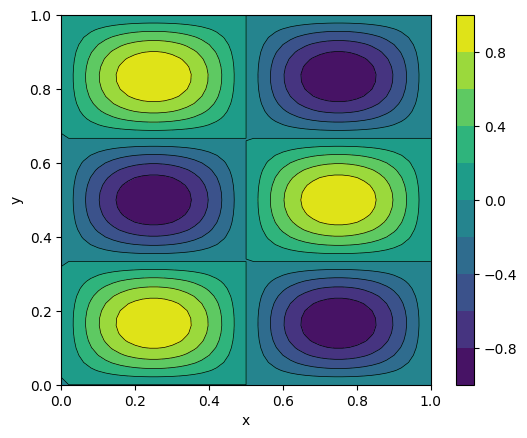

In [5]:
def plot_U(U):
    fig, axes = plt.subplots()
    cs = axes.contourf(X, Y, U, 10, cmap=plt.cm.viridis, vmin=-1, vmax=1)
    axes.contour(X, Y, U, 10, colors='k', linewidths=0.5, linestyles='solid')#, vmin=-1, vmax=1)
    # axes.set_title('Error')
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    axes.set_aspect('equal')
    fig.colorbar(cs)

    return fig, axes

fig, axes = plot_U(U_analytical)
fig.savefig('figures/p3_exact_u.png', dpi=300, bbox_inches='tight')

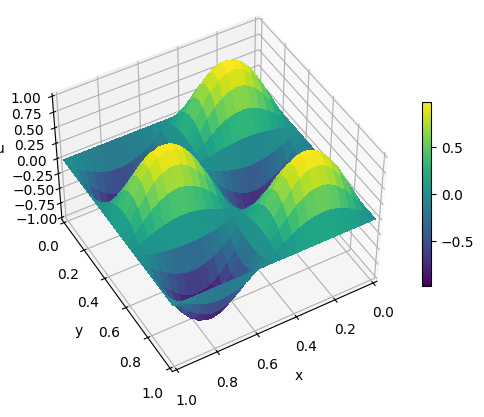

In [6]:
# 3d surface plot of U_analytical
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, U_analytical, cmap=plt.cm.viridis, linewidth=0.1, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_zlim(-1, 1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.colorbar(surf, shrink=0.5)

ax.view_init(45, 60)


In [7]:
# Iterative methods: Jacobi, Gauss-Seidel, SOR

# The idea is to split A=E-F, where E is nonsingular
# then AU=f => U = E^-1 F U + E^-1 f

# Jacobi: E=D and therefore F=-(L+R) --- U = -D^-1 (L+R) U + D^-1 f
# Gauss-Seidel: E=D+L and therefore F=-R --- U = -(D+L)^-1 R U + (D+L)^-1 f
# SOR: U = (D+omega*L)^-1 ((omega-1)*D-omega*R) U + omega(D+omega*L)^-1 f

def iterative(A, f, u0, U_exact=None, tol=1e-10, maxiter=10000, method='jacobi'):
    # D = diags(A.diagonal())
    # L = tril(A, k=-1)
    # R = triu(A, k=1)
    if method == 'jacobi':
        D_inv = diags(A.diagonal()**(-1))  # D^-1
        LplusR = A.copy()
        LplusR.setdiag(0)  # L+R efficiently computed by setting diagonal of A to 0
        C = -D_inv @ (LplusR)  # Jacobi iteration matrix -D^-1 (L+R)
        g = D_inv @ f  # D^-1 f
    elif method == 'gauss-seidel':
        DplusL = tril(A)  # D+L
        R = triu(A, k=1) 
        DplusL_inv = spsolve(DplusL, identity(A.shape[0]))  # (D+L)^-1
        C = -DplusL_inv @ R  # Gauss-Seidel iteration matrix -(D+L)^-1 R
        g = DplusL_inv @ f   # (D+L)^-1 f
    else:
        raise ValueError('Invalid method')
    
    U = u0
    # C = C.reshape(-1, 1)
    print(U.shape, C.shape, g.shape, U_exact.shape)
    res = np.zeros(maxiter)
    for i in range(maxiter):
        U = C @ U + g
        # print(U)
        # print(A.shape, U.shape)
        # if U_exact is not None:
        res[i] = np.linalg.norm(U-U_exact, np.inf)
        # else:
        # res[i] = np.linalg.norm(A @ U - f, np.inf)
        print(res[i])
        if res[i] < tol:
            break
    return U, res[:i]

In [8]:
u0 = np.zeros(f_vec.shape).reshape(-1, 1) 
u0_noisy = u0 + np.random.randn(f_vec.shape[0]).reshape(-1, 1)
U_numerical_ = U_numerical[1:-1, 1:-1].reshape(-1, 1)
u_vec_J, res_J = iterative(A, f_vec.reshape(-1, 1), u0, U_numerical_, method='jacobi')
u_vec_GS, res_GS = iterative(A, f_vec.reshape(-1, 1), u0, U_numerical_, method='gauss-seidel')
u_vec_J_noisy, res_J_noisy = iterative(A, f_vec.reshape(-1, 1), u0_noisy, U_numerical_, method='jacobi')
u_vec_GS_noisy, res_GS_noisy = iterative(A, f_vec.reshape(-1, 1), u0_noisy, U_numerical_, method='gauss-seidel')


(2401, 1) (2401, 2401) (2401, 1) (2401, 1)
0.9876748462783289
0.9750335722379335
0.9625540941670988
0.9502343412353309
0.9380722691167449
0.9260658596508318
0.9142131205075676
0.9025120848568081
0.8909608110419149
0.8795573822575598
0.8682999062316518
0.8571865149113358
0.8462153641530101
0.8353846334163111
0.8246925254620148
0.8141372660538053
0.80371710366386
0.7934303091822026
0.783275175629777
0.7732500178751929
0.763353172355097
0.7535829967981236
0.7439378699523773
0.7344161913164045
0.7250163808736083
0.7157368788300621
0.7065761453556789
0.6975326603286943
0.6886049230834186
0.6797914521612181
0.6710907850646839
0.6625014780149464
0.6540221057120965
0.6456512610986729
0.6373875551261758
0.6292296165245714
0.6211760915747435
0.613225643883859
0.6053769541636096
0.5976287200112886
0.5899796556936736
0.5824284919336722
0.5749739756997
0.5676148699977539
0.5603499536661467
0.553178021172869
0.5460978824155442
0.539108362523945
0.5322083016650361
0.5253965548505128
0.518671991746803

/var/folders/1k/zxb546kd0qv77jvr_rxwwm_40000gp/T/ipykernel_22317/941679052.py:23: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  DplusL_inv = spsolve(DplusL, identity(A.shape[0]))  # (D+L)^-1
/var/folders/1k/zxb546kd0qv77jvr_rxwwm_40000gp/T/ipykernel_22317/941679052.py:23: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  DplusL_inv = spsolve(DplusL, identity(A.shape[0]))  # (D+L)^-1


(2401, 1) (2401, 2401) (2401, 1) (2401, 1)
0.9755950983844609
0.9513217318397895
0.9276450665678309
0.904550610865057
0.8820242206594531
0.8600520912777423
0.8386207494056933
0.8177170452373984
0.797328144809533
0.7774415225166867
0.7580449538038933
0.7391265080324696
0.7206745415152462
0.7026776911987269
0.6851248695620129
0.6680052607195935
0.651308317094772
0.6350237558365918
0.6191415543589915
0.6036519447453761
0.5885454070852134
0.5738126620072683
0.5594446627475272
0.5454325870760585
0.5318999919652713
0.5188107140325522
0.5060506888931314
0.49361192792061725
0.48148658707630376
0.4696669693159453
0.45814552647357376
0.4469148606487874
0.4359677251282409
0.42529702487411836
0.4148958166131894
0.4047573085600974
0.3948748598080385
0.3852419794191324
0.3758523252455823
0.3666997025113027
0.3577780621820932
0.34908149915070785
0.3406042502613762
0.33234069219651174
0.3242853392465319
0.3164328409819398
0.30877797984510624
0.30131566867755977
0.2940409481970466
0.28694898443717853
0

/var/folders/1k/zxb546kd0qv77jvr_rxwwm_40000gp/T/ipykernel_22317/2600069871.py:13: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  DpL_inv = spsolve(DpL, identity(DpL.shape[0]))


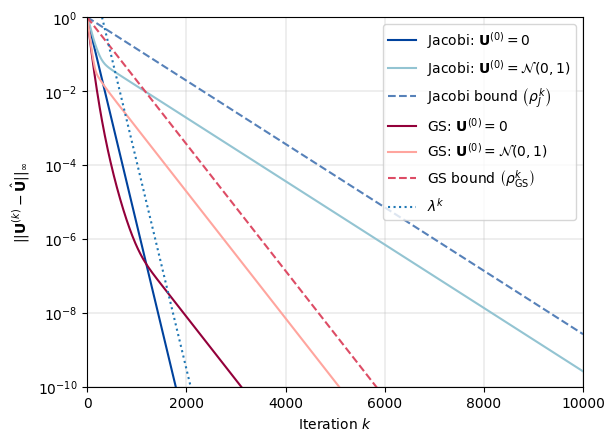

In [14]:
h = 1/N
lmbda = 0.5 * (np.cos(2*np.pi*h) + np.cos(3*np.pi*h))
vector = np.arange(10e3) + 1
theoretical_jacobi_fast = lmbda**vector

# Compute the iteration matrix for Jacobi method
D = diags(A.diagonal())
DpL = D + tril(A, k=-1)
# set the diagonal of A to 0
LpU = A - D
D_inv = diags(D.diagonal()**(-1))
C_jacobi = -D_inv @ LpU
DpL_inv = spsolve(DpL, identity(DpL.shape[0]))
C_gs = -DpL_inv @ triu(A, k=1)

# Compute the spectral radius for both methods
rho_jacobi = max(abs(eigs(C_jacobi, return_eigenvectors=False)))
rho_gs = max(abs(eigs(C_gs, return_eigenvectors=False)))
theoretical_jacobi = rho_jacobi**vector
theoretical_gs = rho_gs**vector

fig, axes = plt.subplots()
axes.semilogy(res_J, c="#00429d", label=r'Jacobi: $\mathbf{U}^{(0)} = 0$')
axes.semilogy(res_J_noisy, c="#93c4d2", label=r'Jacobi: $\mathbf{U}^{(0)} = \mathcal{N}(0,1)$')
axes.semilogy(theoretical_jacobi, '--', c="#5681b9", label=r'Jacobi bound $\left(\rho_J^k\right)$')
axes.semilogy(res_GS, c="#93003a", label=r'GS: $\mathbf{U}^{(0)} = 0$')
axes.semilogy(res_GS_noisy, c="#ffa59e", label=r'GS: $\mathbf{U}^{(0)} = \mathcal{N}(0,1)$')
axes.semilogy(theoretical_gs, '--', c="#dd4c65", label=r'GS bound $\left(\rho_\mathrm{GS}^k\right)$')
axes.semilogy(vector+300, theoretical_jacobi_fast, linestyle='dotted', label=r'$\lambda^k$')
axes.set_xlabel(r'Iteration $k$')
axes.set_ylabel(r'$||\mathbf{U}^{(k)}-\hat{\mathbf{U}}||_{\infty}$')
axes.set_ylim([1e-10, 1e0])
axes.set_xlim([0, 1e4])
axes.grid(linewidth=0.3)
axes.legend()
fig.savefig('figures/p3_iterative_convergence.png', dpi=300, bbox_inches='tight')